In [1]:
import json
import csv

import sys
sys.path.append("../../")
sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

import implicitmodules.torch as dm
from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian
from implicitmodules.torch.Attachment.attachment_varifold import VarifoldAttachment2D

torch.set_default_tensor_type(torch.DoubleTensor)
dtype = torch.float64

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/rosa/DefmodEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
with open('../../data/nutsdata.pickle', 'rb') as f:
            lines, sigv, sig = pickle.load(f)

source = torch.tensor(lines[0][::2], requires_grad=True, dtype=torch.float64)[1:]
target = torch.tensor(lines[1][::2]  , requires_grad=True, dtype=torch.float64)[1:]


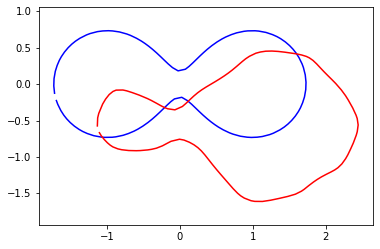

In [3]:
plt.plot(source[:,0].detach(), source[:,1].detach(), '-b')
plt.plot(target[:,0].detach(), target[:,1].detach(), '-r')
plt.axis('equal')
plt.show()

In [4]:
source0 = source
source1 = source + torch.ones(len(source),1) * torch.tensor([[1.5, 2]])

target0 = -target + torch.ones(len(target),1) * torch.tensor([[0, 0]])
target1 = target + torch.ones(len(target),1) * torch.tensor([[1.5, 2.5]])

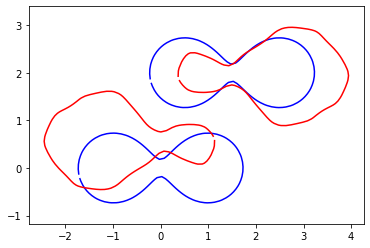

In [5]:
plt.plot(source0[:,0].detach(), source0[:,1].detach(), '-b')
plt.plot(source1[:,0].detach(), source1[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '-r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '-r')
plt.axis('equal')
plt.show()

In [6]:
source_deformable0 = dm.Models.DeformablePoints(source0)
source_deformable1 = dm.Models.DeformablePoints(source1)
target_deformable0 = dm.Models.DeformablePoints(target0)
target_deformable1 = dm.Models.DeformablePoints(target1)

scale_scaling = 0.7
scaling00 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[-1.,0.]], dtype=torch.float64, requires_grad=True))
scaling01 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[1.,0.]], dtype=torch.float64, requires_grad=True))
scaling10 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[0.5,2.]], dtype=torch.float64, requires_grad=True))
scaling11 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[2.5,2.]], dtype=torch.float64, requires_grad=True))

scale_translation = 5.
translation0 = dm.DeformationModules.Translations(2, 1, scale_translation, gd=torch.tensor([[0., 0.]]))
translation0.to_(dtype)
translation1 = dm.DeformationModules.Translations(2, 1, scale_translation, gd=torch.tensor([[1.5, 2.]]))
translation1.to_(dtype)

compound_man = dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), source_deformable1.silent_module.manifold.clone(requires_grad=True),
                                              scaling00.manifold.clone(requires_grad=True), scaling01.manifold.clone(requires_grad=True), 
                                              scaling10.manifold.clone(requires_grad=True), scaling11.manifold.clone(requires_grad=True), 
                                              translation0.manifold.clone(requires_grad=True), translation1.manifold.clone(requires_grad=True)]), 

sigmas_varifold = [1., 0.2]
attach = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

shoot_solver = 'torch_euler'
shoot_it = 10

model = dm.Models.RegistrationModel([source_deformable0, source_deformable1], [scaling00, scaling01, scaling10, scaling11, translation0, translation1], [attach, attach], lam=10.)

In [7]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable0, target_deformable1], 100, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

Starting optimization with method Scipy L-BFGS-B
Initial cost={'deformation': 0.0, 'attach': 210.5389657159044}
Time: 8.966559795999274
Iteration: 0
Costs
deformation=0.015053091096648558
attach=194.21399494186957
Total cost=194.22904803296623
Time: 10.533194077999724
Iteration: 1
Costs
deformation=0.016674836658437803
attach=194.04418942436408
Total cost=194.06086426102252
Time: 11.941597432998606
Iteration: 2
Costs
deformation=0.019940942758538218
attach=193.55599629117248
Total cost=193.57593723393103
Time: 13.364720077999664
Iteration: 3
Costs
deformation=0.029705886955100885
attach=192.34975716926505
Total cost=192.37946305622015
Time: 14.750032430998544
Iteration: 4
Costs
deformation=0.04076192806652637
attach=191.23286761806094
Total cost=191.27362954612747
Time: 17.91859693799961
Iteration: 5
Costs
deformation=0.09617052884260147
attach=178.35321344293166
Total cost=178.44938397177427
Time: 21.354401611999492
Iteration: 6
Costs
deformation=0.3590674055028976
attach=151.12532433

Time: 88.21815133599921
Iteration: 39
Costs
deformation=1.9230854373987583
attach=116.34702773892295
Total cost=118.2701131763217
Time: 89.59705530499923
Iteration: 40
Costs
deformation=2.185609105848656
attach=112.9659199929266
Total cost=115.15152909877526
Time: 91.5007081219992
Iteration: 41
Costs
deformation=4.267101903661271
attach=99.82911580935226
Total cost=104.09621771301353
Time: 95.67327336800008
Iteration: 42
Costs
deformation=5.934612944776932
attach=92.80267628367301
Total cost=98.73728922844994
Time: 99.79849623100017
Iteration: 43
Costs
deformation=6.966744491690236
attach=87.7286654488279
Total cost=94.69540994051813
Time: 103.10785698399923
Iteration: 44
Costs
deformation=8.311914922358905
attach=81.3790430803929
Total cost=89.69095800275181
Time: 106.83568084899889
Iteration: 45
Costs
deformation=11.322208324694305
attach=68.9161296463224
Total cost=80.2383379710167
Time: 109.96335609499874
Iteration: 46
Costs
deformation=12.131603432542704
attach=65.5966751872669
To

Time: 166.78104349000023
Iteration: 78
Costs
deformation=10.264402746379348
attach=35.15645425652579
Total cost=45.42085700290514
Time: 169.8341620479987
Iteration: 79
Costs
deformation=10.459798693835767
attach=34.77746645369607
Total cost=45.237265147531836
Time: 171.35187893999864
Iteration: 80
Costs
deformation=10.706289787409052
attach=34.08935925039426
Total cost=44.795649037803315
Time: 172.87041605899867
Iteration: 81
Costs
deformation=10.740622704622881
attach=33.77134198024553
Total cost=44.51196468486841
Time: 174.2947068829999
Iteration: 82
Costs
deformation=10.636734700808802
attach=33.78240960852697
Total cost=44.41914430933577
Time: 175.73155901399878
Iteration: 83
Costs
deformation=10.535901264672576
attach=33.83705322263598
Total cost=44.372954487308554
Time: 177.15528740099944
Iteration: 84
Costs
deformation=10.442856770224552
attach=33.89331273621001
Total cost=44.33616950643456
Time: 178.58235622199936
Iteration: 85
Costs
deformation=10.319324340647956
attach=34.004

In [8]:
out = model.compute_deformed(shoot_solver, shoot_it)

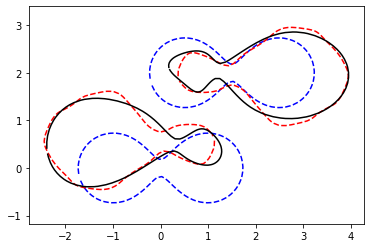

In [9]:
shape0_defo = out[0][0]
shape1_defo = out[1][0]

source = [source0, source1]
target = [target0, target1]

plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '--b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '--b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')
plt.plot(shape0_defo[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo[:,0].detach(), shape1_defo[:,1].detach(), '-k')
plt.axis('equal')
plt.show()

In [10]:
fac = 5
grid_resolution = [fac*9, fac*4]
gridmod = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(torch.cat([source0, source1])).scale(1.5), grid_resolution)

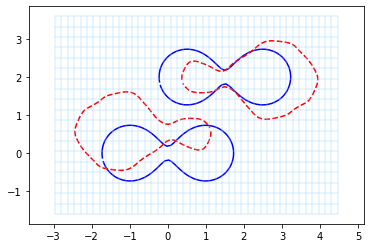

In [11]:
grid = gridmod.togrid()

ax = plt.subplot()
plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()

In [12]:
pts = gridmod.manifold.gd.clone().contiguous()
grid_deformable = dm.Models.DeformablePoints(pts)

In [13]:
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)

silent = copy.copy(modules[0])
modlist = copy.copy(modules[1:])

In [15]:
Ham_grid = dm.HamiltonianDynamic.Hamiltonian([silent, gridmod, *modlist])

shoot(Ham_grid, shoot_solver, shoot_it)
shape0_defo_grid = Ham_grid.module.modules[0].manifold.gd
shape1_defo_grid = Ham_grid.module.modules[2].manifold.gd

grid_deformed = gridmod.togrid()

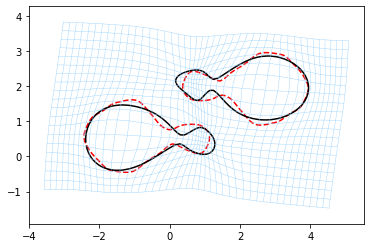

In [19]:
ax = plt.subplot()
#plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
#plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')
plt.plot(shape0_defo_grid[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo_grid[:,0].detach(), shape1_defo[:,1].detach(), '-k')

dm.Utilities.plot_grid(ax, grid_deformed[0], grid_deformed[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()